In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [16]:
COUNTRY = "Yemen"

In [17]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/data/" + COUNTRY + "/"

In [18]:
# Load the dataset of the training sets.
train_smooth = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train_smooth.index.name = "Datetime"
train_smooth.index = pd.to_datetime(train_smooth.index)
freq = "D"
train_smooth.index.freq = freq

In [19]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [20]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [21]:
TRAIN = train_smooth.copy()

In [22]:
TEST_SIZE = 30
FREQ = TRAIN.index.freq

In [23]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [24]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

In [25]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN)
TEST_TARGET_SETS = find_multiple_sets(test)

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [28]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [29]:
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = 1).apply(lambda x: normalization(x, (MIN, MAX)))

In [30]:
# Plot time-series.
#TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines")

In [31]:
def denormalization(group_scaled, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[indicator]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

In [32]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN_NORMALIZED)
TEST_TARGET_SETS = find_multiple_sets(test)

## Results from Grid Search

In [26]:
PATH_TO_RESULTS = "./isi_server/output1/"

In [27]:
results = pd.read_csv(PATH_TO_RESULTS + "grid_search.csv")
results.head()

,1 Month Anomaly (%) Rainfall,3 Months Anomaly (%) Rainfall,C,Cereals and tubers,Exchange rate (USD/LCU),FCS,Fatality,Lat,Lon,NDVI Anomaly,Population,Rainfall (mm),Ramadan,gamma,rCSI,h,r2,val_loss,train_loss
0,61.0,36.0,100.0,76.0,31.0,16,36.0,NaN,0.0,NaN,NaN,51.0,36.0,0.001,6.0,1,0.942470,0.001492,0.001728
1,61.0,36.0,100.0,76.0,31.0,16,36.0,NaN,0.0,NaN,NaN,51.0,36.0,0.001,6.0,2,0.937915,0.001567,0.001859
2,61.0,36.0,100.0,76.0,31.0,16,36.0,NaN,0.0,NaN,NaN,51.0,36.0,0.001,6.0,3,0.934604,0.001700,0.001950
3,61.0,36.0,100.0,76.0,31.0,16,36.0,NaN,0.0,NaN,NaN,51.0,36.0,0.001,6.0,4,0.929957,0.001868,0.002081
4,61.0,36.0,100.0,76.0,31.0,16,36.0,NaN,0.0,NaN,NaN,51.0,36.0,0.001,6.0,5,0.924431,0.002067,0.002238


## Forecasting

In [43]:
from sklearn.svm import SVR

In [44]:
FORECASTING_NORMALIZED = test.copy()

In [45]:
for h in range(TEST_SIZE):
    # Get the best parameters for the prediction horizon h.
    best_params = results[results.h == (h+1)].loc[results[results.h == (h+1)].val_loss.idxmin()].to_dict()

    lags_dict = {key: best_params[key] for key in PREDICTORS} 
    for k,v in lags_dict.items():
        if v >= 0:
            lags_dict[k] = int(v)
        else:
            lags_dict[k] = None

    X_train_list, y_train_list = list(), list()
    X_test_dict = dict()
    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        for PROVINCE in PROVINCES:
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = True, h = h+1, return_dataframe = True,
                                                                   feature_time = True, validation = False, return_single_level = True, 
                                                                   dtype = np.float64)
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            
            # Add the test sample of the province of the current set into a dictionary.
            X_test_dict[(PROVINCE, i)] = X_test

    X_train = pd.concat(X_train_list).reset_index(drop = True).values
    y_train = pd.concat(y_train_list).reset_index(drop = True).values.flatten()

    print("Training %s samples for the prediction horizon h: %d" % (str(X_train.shape), h+1))
    model = SVR(gamma = best_params["gamma"], kernel = "rbf", C = best_params["C"])
    model.fit(X_train, y_train)
    
    # Prediction.
    for i, test_set in enumerate(TEST_TARGET_SETS):
        for PROVINCE in PROVINCES:
            X_test = X_test_dict[(PROVINCE, i)].values
            y_hat = model.predict(X_test)[0]
            FORECASTING_NORMALIZED[(PROVINCE, "FCS")].loc[test_set.index[h]] = y_hat

Training (6000, 353) samples for the prediction horizon h: 1
Training (5940, 353) samples for the prediction horizon h: 2
Training (5880, 353) samples for the prediction horizon h: 3
Training (5820, 353) samples for the prediction horizon h: 4
Training (5760, 353) samples for the prediction horizon h: 5
Training (5700, 353) samples for the prediction horizon h: 6
Training (5340, 363) samples for the prediction horizon h: 7
Training (5280, 363) samples for the prediction horizon h: 8
Training (5220, 363) samples for the prediction horizon h: 9
Training (5160, 363) samples for the prediction horizon h: 10
Training (5100, 363) samples for the prediction horizon h: 11
Training (5040, 363) samples for the prediction horizon h: 12
Training (4980, 363) samples for the prediction horizon h: 13
Training (4920, 448) samples for the prediction horizon h: 14
Training (4860, 448) samples for the prediction horizon h: 15
Training (4200, 413) samples for the prediction horizon h: 16
Training (4140, 4

In [46]:
# Denormalization.
FORECASTING = denormalization(FORECASTING_NORMALIZED, "FCS", (MIN, MAX), SCALERS)

In [47]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [48]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [49]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    # Reduce columns to have only the columns of the provinces.
    test_set.columns = test_set.columns.get_level_values(0)
    forecasting_set.columns = forecasting_set.columns.get_level_values(0)
    # Compute losses.
    for PROVINCE in PROVINCES:
        loss = mean_squared_error(test_set[PROVINCE], forecasting_set[PROVINCE])
        losses.append(loss)
        loss_h = mean_squared_error([test_set[PROVINCE]], [forecasting_set[PROVINCE]], multioutput = "raw_values")
        losses_h.append(loss_h)

In [50]:
overall_mse = np.mean(losses)
overall_mse

29.965245270737434

In [51]:
# Load naive model forecasting results.
naive = np.load("../Naive_" + COUNTRY + ".npy")

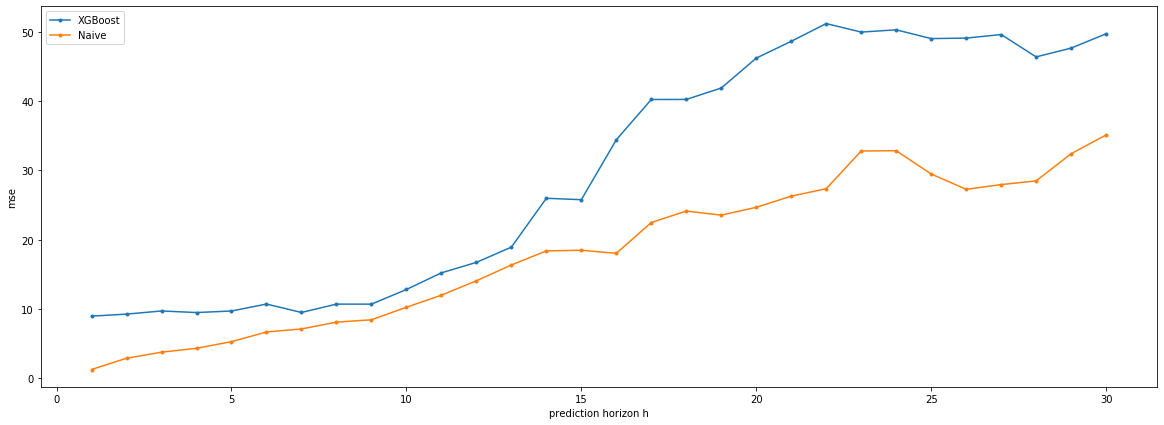

In [52]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-", label = "XGBoost")
ax.plot(naive[0], naive[1], ".-", label = "Naive")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10)
ax.legend();